In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 KB 9.4 MB/s eta 0:00:00


In [ ]:
# load package
import shap
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.models import Sequential
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
# reshape and normalize data
x_train = x_train.reshape(50000, 32, 32, 3).astype("float32") / 255
x_test = x_test.reshape(10000, 32, 32, 3).astype("float32") / 255
y_train = y_train.reshape(50000,)
y_test = y_test.reshape(10000,)

170498071/170498071 [==============================] - 14s 0us/step


In [ ]:
# define the model architecture
inputs = keras.Input(shape=(32, 32, 3))
x = keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = keras.layers.MaxPooling2D((2, 2))(x)
x = keras.layers.Conv2D(128, (3, 3), activation='relu')(inputs)
x = keras.layers.MaxPooling2D((2, 2))(x)
x = keras.layers.Conv2D(64, (3, 3), activation='relu')(inputs)
x = keras.layers.MaxPooling2D((2, 2))(x)
x = keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = keras.layers.MaxPooling2D((2, 2))(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dense(64, activation='relu')(x)
outputs = keras.layers.Dense(10, activation='softmax')(x)
# inputs and outputs
model = keras.Model(inputs=inputs, outputs=outputs, name="test_for_shap")
# compile the model
model.compile(
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      optimizer=keras.optimizers.Adam(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
  )
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs = 10)

Epoch 1/10
1563/1563 [==============================] - 20s 5ms/step - loss: 1.4272 - sparse_categorical_accuracy: 0.4871 - val_loss: 1.1969 - val_sparse_categorical_accuracy: 0.5781
Epoch 2/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.1069 - sparse_categorical_accuracy: 0.6091 - val_loss: 1.0851 - val_sparse_categorical_accuracy: 0.6204
Epoch 3/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.9405 - sparse_categorical_accuracy: 0.6695 - val_loss: 1.0305 - val_sparse_categorical_accuracy: 0.6386
Epoch 4/10
1563/1563 [==============================] - 9s 5ms/step - loss: 0.8057 - sparse_categorical_accuracy: 0.7159 - val_loss: 1.0213 - val_sparse_categorical_accuracy: 0.6508
Epoch 5/10
1563/1563 [==============================] - 7s 4ms/step - loss: 0.6926 - sparse_categorical_accuracy: 0.7567 - val_loss: 1.0761 - val_sparse_categorical_accuracy: 0.6411
Epoch 6/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.5827 - spar

In [ ]:
# class label list
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
# example image for each class
images_dict = dict()
for i, l in enumerate(y_train):
  if len(images_dict)==10:
    break
  if l not in images_dict.keys():
    images_dict[l] = x_train[i].reshape((32, 32,3))
images_dict = dict(sorted(images_dict.items()))
    
# example image for each class for test set
x_test_dict = dict()
for i, l in enumerate(y_test):
  if len(x_test_dict)==10:
    break
  if l not in x_test_dict.keys():
    x_test_dict[l] = x_test[i]
# order by class
x_test_each_class = [x_test_dict[i] for i in sorted(x_test_dict)]
x_test_each_class = np.asarray(x_test_each_class)
# Compute predictions
predictions = model.predict(x_test_each_class)
predicted_class = np.argmax(predictions, axis=1)

1/1 [==============================] - 0s 120ms/step


In [ ]:
# plot actual and predicted class
def plot_actual_predicted(images, pred_classes):
  fig, axes = plt.subplots(1, 11, figsize=(16, 15))
  axes = axes.flatten()
  
  # plot
  ax = axes[0]
  dummy_array = np.array([[[0, 0, 0, 0]]], dtype='uint8')
  ax.set_title("Base reference")
  ax.set_axis_off()
  ax.imshow(dummy_array, interpolation='nearest')
  # plot image
  for k,v in images.items():
    ax = axes[k+1]
    ax.imshow(v, cmap=plt.cm.binary)
    ax.set_title(f"True: %s \nPredict: %s" % (class_names[k], class_names[pred_classes[k]]))
    ax.set_axis_off()
  plt.tight_layout()
  plt.show()

In [ ]:
# select backgroud for shap
background = x_train[np.random.choice(x_train.shape[0], 1000, replace=False)]
# DeepExplainer to explain predictions of the model
explainer = shap.DeepExplainer(model, background)
# compute shap values
shap_values = explainer.shap_values(x_test_each_class)

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


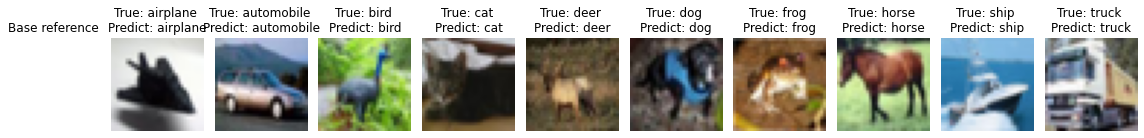

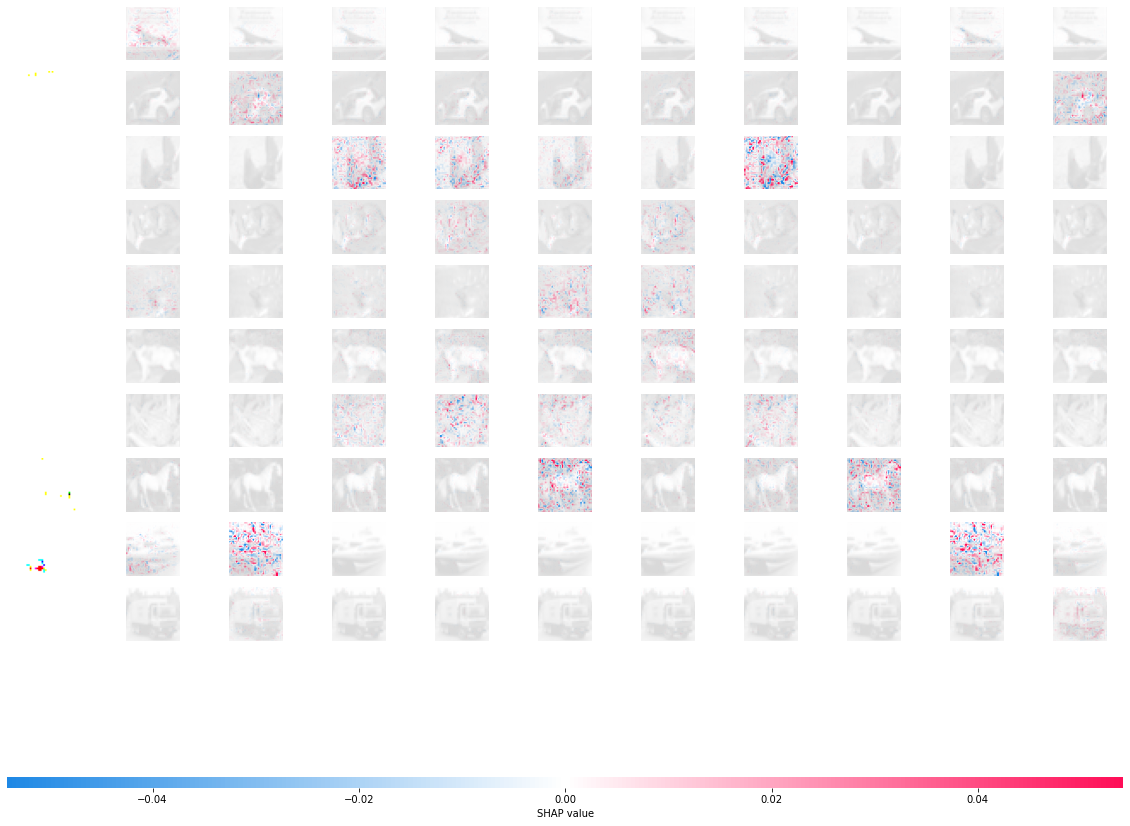

In [ ]:
# plot SHAP values
plot_actual_predicted(images_dict, predicted_class)
print()
shap.image_plot(shap_values, x_test_each_class * 255)